## Pf6 heterozygous calls

My Drive/GitHub/gtg/Pf6_het_calls_230322.ipynb

This code examines the frequency distribution of heterozgous genotype calls in the [Pf6 dataset](https://www.malariagen.net/sites/default/files/File8_Pf_6_README_20191010_0.txt).  It uses downloaded Zarr data and sample metadata that are stored locally on ThinkPad_2022 in 'C:\\Users\\dkwia\\Data\\Pf6\\'. 

* extract lists of samples (n = 7,113) and variant properties (n = 6,051,696) as arrays

* select variants that are high-quality biallelic coding SNPs (n = 502,221)

* extract allele depth for high-quality SNPs from Zarr into `allele_depth_1.npy`.  We do this in chunks of 10,000 variants at a time to avoid memory problems

* extract sample metadata from samples.txt into a dataframe

* read info about sample QC into an array

* extract allele depth for high-quality SNPs and high-quality samples (n = 5,970) into `allele_depth_2.npy` 

* calculate within-host heterozygosity for each SNP in each sample and save to `wiho_het.npy`

* calculate mean within-host heterozygosity for each SNP across all samples and save to a list called wiho_het_per_snp

* using wiho_het_per_snp, create `snp_filter` to filter out potential hyperhet SNPs

* create `sample_filter` to select samples from a particular geographical region

* calculate $\pi_W$ for each sample, using mean within-host heterozygosity per sample, and allowing for the number of SNPs ascertained and the size of coding regions

* plot a histogram of nucleotide diversity per sample

* view the histogram for different filter cutoffs for hyperhet SNPs and for different regions e.g. West Africa vs Southeast Asia

In [1]:
import zarr
import numpy as np
import pandas as pd
import json
import math
import time
import matplotlib.pyplot as plt
import statistics as stat

In [2]:
data_path = 'C:\\Users\\dkwia\\Data\\Pf6\\'

callset = zarr.open_group(data_path + 'Pf_6.zarr', mode = 'r')
callset.tree()

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='calldata', nodes=(Node(disabled=Tru…

# Run

#### Extract lists of samples and variant properties as arrays
* 7,113 samples 
* 6,051,696 variants

#### Select high-quality biallelic coding SNPs
* high quality means 'filter_pass == True' & 'vqslod > 3'
* 502,221 variants meet criteria
* `select` is a mask for an array of 6,051,696 variants

In [3]:
samples = callset['samples'][:]

filter_pass = callset['variants/FILTER_PASS'][:]
vqslod = callset['variants/VQSLOD'][:]
snp = callset['variants/is_snp'][:]
coding = callset['variants/CDS'][:]
numalt = callset['variants/numalt'][:]
effect = callset['variants/SNPEFF_EFFECT'][:]

# select biallelic synonymous coding SNPs and create a mask
select = (filter_pass == True) & (snp == True) & (numalt == 1) & (coding == True) & (vqslod > 3)

# & (effect == 'SYNONYMOUS_CODING') 

selected_snps = np.count_nonzero(select == True)

total_variants = len(snp)
total_samples = len(samples)

print('There are {0:d} variants and {1:d} selected SNPs in {2:d} samples.'.
      format(total_variants, selected_snps, total_samples))

There are 6051696 variants and 502221 selected SNPs in 7113 samples.


#### Save allele depths for selected SNPs in `allele_depth_1.npy`
* Use the `select` mask created above to pull out selected SNPs
* Copy allele depths for selected SNPs from 'calldata/AD' into `allele_depth_1`
  * calldata/AD allows for multiallelic loci by containing allele depth for up to 7 variant alleles
  * Since we focus on biallelic SNPs we include only the first two alleles from calldata/AD
* This file is 14GB

In [ ]:
# We extract allele depth data for selected SNPs into a numpy array.
# We do this in chunks of 10000 variants at a time to avoid memory problems.
# This step can be omitted by retrieving saved data in the next section.

ad = callset['calldata/AD']

allele_depth_1 = 9 * np.ones((selected_snps, total_samples, 2), dtype=np.int16)

selected_snp_id = 0

chunk_size = 10000

for i in range(int(total_variants / chunk_size)):
    
    start_time = time.time()
    
    chunk = ad[(i * chunk_size) : ((i + 1) * chunk_size), :, :2]
    
    chunk_snps = 0

    for j in range(chunk_size):
        
        variant_id = i * chunk_size + j
    
        if select[variant_id] == True:
            
            allele_depth_1[selected_snp_id, :, :] = chunk[j, :, :]
            
            selected_snp_id += 1
            
            chunk_snps += 1
               
    chunk_time = time.time() - start_time
        
    print('chunk {0:d} had {1:d} SNPs and took {2:.2f} seconds'.
          format(i, chunk_snps, chunk_time))

start_time = time.time()

chunk = ad[(i * chunk_size) :, :, :]

chunk_snps = 0

for j in range(total_variants % chunk_size):
    
    if select[(i + 1) * chunk_size + j] == True:
            
        allele_depth_1[selected_snp_id, :, :] = chunk[j, :, :]
        
        selected_snp_id += 1
            
        chunk_snps += 1
               
    chunk_time = time.time() - start_time
        
print('chunk {0:d} had {1:d} SNPs and took {2:.1f} seconds'.
     format(i, chunk_snps, chunk_time))

total_snps = selected_snp_id

print('total of {0:d} selected snps'.format(total_snps))

np.save(data_path + '221221_selected_gt_1', allele_depth_1)

# Run

#### Select samples and list region of each selected sample
* 'Population' in Pf6_samples.txt gives: 'SAM'=South America, 'WAF'=West Africa, 'CAF'=Central Africa, 'EAF'=East African, 'SAS'=South Asia, 'WSEA'=Western SE Asia, 'ESEA'=Eastern SE Asia, 'OCE'=Oceania

In [10]:
df = pd.read_table(data_path + 'samples.txt')

select_sample = np.array(df['QC pass'])

selected_samples = np.count_nonzero(select_sample == True)

print('There are', str(selected_samples), 'selected samples that passed QC')

region = []

for i in range(total_samples):
    
    if select_sample[i] == True:
        
        region.append(df['Population'][i])
        
with open(data_path + "230316_region", "w") as fp:
    json.dump(region, fp)

There are 5970 selected samples that passed QC


#### Copy allele depth for QC pass samples from `allele_depth_1` into `allele_depth_2`
* 'QC pass' field in samples.txt gives True/False
* Save as .npy file (~11.7GB) so that this step only has to be run once

In [35]:
allele_depth_1 = np.load(data_path + '221221_selected_gt_1.npy')

allele_depth_2 = 9 * np.ones((selected_snps, selected_samples, 2), dtype=np.int16)

for i in range(total_samples):
    
    if select_sample[i] == True:
        
        allele_depth_2[:, selected_sample_id, :] = allele_depth_1[:, i, :]
        
np.save(data_path + '221221_selected_gt_2', allele_depth_2)

There are 5970 selected samples that passed QC


#### Calculate within-host heterozygosity for each SNP and save as `wiho_het.npy`
* if ref_allele + alt_allele == 1 then write het = 0.
* this file is 23.5GB because dtype=float

In [3]:
allele_depth_2 = np.load(data_path + '221221_selected_gt_2.npy') #, mmap_mode = 'r')

selected_samples = len(allele_depth_2[0, :, 0])

selected_snps = len(allele_depth_2[: , 0, 0])

print(selected_samples)
print(selected_snps)

5970
502221


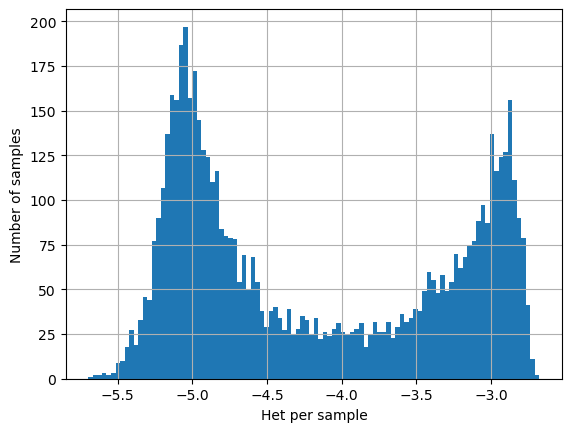

In [4]:
# All regions - only SNPs with het < 0.02

with open(data_path + "230317_het_per_sample_ALL", "r") as filepath:
    het_per_sample = json.load(filepath)
    
het_per_sample_nonzero = [x for x in het_per_sample]
log_het_per_sample = [math.log(x, 10) for x in het_per_sample_nonzero]
plt.hist(log_het_per_sample, bins = 100)
plt.xlabel('Het per sample')
plt.ylabel('Number of samples')
plt.grid()
plt.show()

In [5]:
wiho_het = np.load(data_path + '230318_wiho_het.npy', mmap_mode = 'r')
snp_count = wiho_het.shape[0]
sample_count = wiho_het.shape[1]

sample_het = np.array(het_per_sample)

lo_het = sample_het < 3e-5
hi_het = sample_het > 3e-4
med_het = (sample_het >= 3e-5) & (sample_het <= 3e-4)

In [50]:
i = 61

maf = []

if lo_het[i] == True:
    
    for j in range(snp_count):
        
        x = allele_depth_2[j, i, 0]
            
        y = allele_depth_2[j, i, 1]
            
        z = min(x, y)
    
        a = x + y
    
        if a != 0:
        
            b = z/a
    
            if b > 0.05:
                
                maf.append(b)
        
    mean_maf = stat.mean(maf)
    print(maf)

else:
    
    print("Not low het sample")

[0.29411766, 0.083333336, 0.055555556, 0.055555556, 0.05, 0.09090909, 0.05882353, 0.05263158, 0.4074074, 0.1923077, 0.125, 0.078947365, 0.125, 0.05, 0.071428575, 0.06451613, 0.05263158, 0.05882353, 0.051282052, 0.09090909, 0.05, 0.074074075, 0.055555556, 0.051282052, 0.083333336, 0.05882353, 0.06666667, 0.11764706, 0.071428575, 0.06451613, 0.0952381, 0.055555556, 0.05, 0.0625, 0.3243243, 0.14285715, 0.11764706, 0.14285715, 0.0625, 0.074074075, 0.07692308, 0.05882353, 0.05882353, 0.07692308, 0.08, 0.06451613, 0.06451613, 0.0625, 0.14285715, 0.06896552, 0.051282052, 0.10526316, 0.06666667, 0.05, 0.06896552, 0.07692308, 0.05263158, 0.05, 0.055555556]


In [43]:
count_minor_alleles = []

i = 56

for j in range(snp_count):
        
    x = allele_depth_2[j, i, 0]
            
    y = allele_depth_2[j, i, 1]
            
    z = min(x, y)
        
    if z != 0:
                
        count_minor_alleles.append(z)
        
mean_count_minor_alleles = stat.mean(count_minor_alleles)
print(count_minor_alleles[:10000])

[1, 2, 11, 1, 4, 7, 12, 2, 3, 7, 9, 10, 1, 5, 5, 14, 13, 14, 9, 8, 11, 5, 8, 5, 7, 4, 10, 6, 11, 6, 7, 6, 8, 9, 10, 10, 12, 9, 10, 9, 8, 15, 13, 11, 13, 8, 10, 8, 8, 11, 6, 10, 6, 2, 8, 7, 10, 12, 10, 10, 9, 9, 13, 15, 10, 10, 5, 5, 1, 9, 12, 7, 9, 6, 13, 9, 6, 6, 7, 9, 11, 10, 3, 3, 3, 5, 5, 4, 3, 4, 3, 4, 1, 1, 1, 2, 1, 2, 4, 2, 3, 6, 7, 7, 5, 2, 3, 5, 4, 3, 5, 5, 4, 6, 3, 1, 6, 4, 1, 2, 5, 2, 1, 1, 4, 4, 5, 1, 3, 5, 1, 3, 2, 4, 3, 1, 1, 2, 2, 1, 3, 7, 6, 6, 4, 8, 9, 3, 4, 8, 5, 5, 2, 11, 5, 26, 1, 2, 2, 2, 2, 2, 2, 1, 4, 4, 4, 2, 6, 4, 7, 7, 5, 8, 7, 13, 1, 9, 6, 7, 6, 96, 123, 32, 32, 11, 5, 9, 9, 8, 11, 7, 5, 8, 8, 8, 10, 1, 1, 1, 12, 7, 10, 5, 1, 5, 4, 5, 5, 11, 5, 4, 12, 2, 10, 5, 5, 4, 1, 6, 9, 6, 5, 6, 4, 1, 1, 8, 1, 7, 5, 5, 9, 4, 8, 7, 10, 6, 12, 4, 11, 1, 7, 6, 2, 7, 1, 4, 4, 4, 5, 9, 9, 7, 11, 7, 6, 2, 1, 1, 1, 2, 2, 1, 1, 3, 1, 5, 3, 7, 5, 11, 7, 8, 3, 4, 7, 1, 3, 8, 5, 9, 5, 4, 2, 7, 1, 3, 1, 6, 3, 1, 4, 1, 6, 2, 2, 1, 3, 1, 4, 6, 2, 2, 2, 5, 5, 1, 2, 11, 14, 10, 7, 2, 3

In [128]:
count_minor_alleles = []

i = 91
    
if lo_het[i] == True:
        
    for j in range(snp_count):
        
        x = allele_depth_2[j, i, 0]
            
        y = allele_depth_2[j, i, 1]
            
        z = min(x, y)
        
        if z != 0:
                
            count_minor_alleles.append(z)
        
mean_count_minor_alleles = stat.mean(count_minor_alleles)
print(count_minor_alleles[:10000])

[35, 80, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 12, 2, 43, 58, 54, 53, 51, 45, 11, 11, 10, 15, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 15, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 4, 1, 3, 5, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 2, 25]


In [38]:
sum_minor_alleles = []

for i in range(50):
    
    minor_alleles = []

    if lo_het[i] == True:
        
        for j in range(snp_count):
        
            x = allele_depth_2[j, i, 0]
            
            y = allele_depth_2[j, i, 1]
            
            z = min(x, y)
        
            if z != 0:
                
                minor_alleles.append(z)
                
        sum_minor_alleles.append(sum(minor_alleles))
        
mean_sum_minor_alleles = stat.mean(sum_minor_alleles)
print(mean_sum_minor_alleles)
print(sum_minor_alleles)

1684
[2242, 1090, 2469, 1339, 1077, 1046, 880, 7465, 922, 3861, 807, 1931, 2996, 648, 886, 1424, 1840, 542, 882, 1216, 2169, 941, 3283, 699, 296, 1936, 594]


In [133]:
sum_minor_alleles = []

for i in range(50):
    
    minor_alleles = []

    if lo_het[i] == True:
        
        for j in range(snp_count):
        
            x = allele_depth_2[j, i, 0]
            
            y = allele_depth_2[j, i, 1]
            
            z = min(x, y)
        
            if z != 0:
                
                minor_alleles.append(z)
                
        sum_minor_alleles.append(sum(minor_alleles))
        
mean_sum_minor_alleles = stat.mean(sum_minor_alleles)
print(mean_sum_minor_alleles)
print(sum_minor_alleles)

1684
[2242, 1090, 2469, 1339, 1077, 1046, 880, 7465, 922, 3861, 807, 1931, 2996, 648, 886, 1424, 1840, 542, 882, 1216, 2169, 941, 3283, 699, 296, 1936, 594]


In [37]:
count_variants = []

for i in range(sample_count):
    
    if lo_het[i] == True:
        
        x = np.count_nonzero(wiho_het[: , i])
        
        count_variants.append(x)
        
mean_count_variants = stat.mean(count_variants)
print(mean_count_variants)

412.42896174863387


In [9]:
count_variants = []

for i in range(sample_count):
    
    if lo_het[i] == True:
        
        x = np.count_nonzero(wiho_het[: , i])
        
        count_variants.append(x)
        
mean_count_variants = stat.mean(count_variants)
print(mean_count_variants)

412.42896174863387


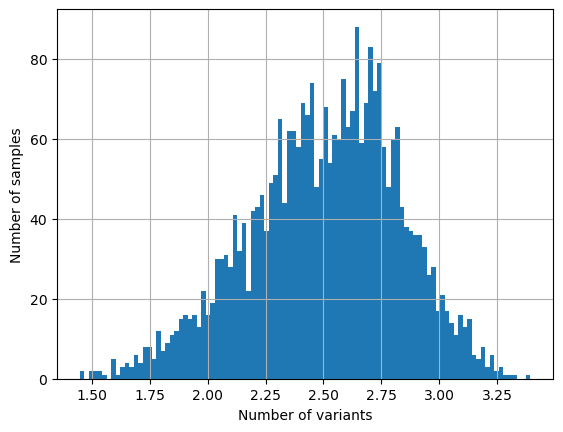

In [20]:
log_count_variants = [math.log(x, 10) for x in count_variants]
plt.hist(log_count_variants, bins = 100)
plt.xlabel('Number of variants')
plt.ylabel('Number of samples')
plt.grid()
plt.show()

In [9]:
mean_allele_depth_sample = []

for i in range(selected_samples):
    
    mean_allele_depth = np.mean(allele_depth_2[:, i, 0]) + np.mean(allele_depth_2[:, i, 1])

    mean_allele_depth_sample.append(mean_allele_depth)

mean_allele_depth_all_samples = stat.mean(mean_allele_depth_sample)

print(mean_allele_depth_all_samples)

NameError: name 'stats' is not defined

In [11]:
mean_allele_depth_all_samples = stat.mean(mean_allele_depth_sample)
print(mean_allele_depth_all_samples)

75.9820107314465


In [ ]:
allele_depth_2 = np.load(data_path + '221221_selected_gt_2.npy') #, mmap_mode = 'r')

selected_samples = len(allele_depth_2[0, :, 0])

wiho_het = np.ones((selected_snps, selected_samples), dtype=float32)

for i in range(selected_snps):
    for j in range(selected_samples):
        
        ref_allele = allele_depth_2[i, j, 0]
        alt_allele = allele_depth_2[i, j, 1]
        denominator = ref_allele + alt_allele
        if denominator != 0:
            allele_freq = alt_allele / denominator
            het = 2 * allele_freq * (1 - allele_freq)
        else:
            het = 0 # this is a hack
            
        wiho_het[i, j] = het

    if i % 100 == 0:
        print(i)
        
np.save(data_path + '230113_wiho_het.npy', wiho_het)

#### Calculate mean within-host heterozygosity for each SNP

In [7]:
wiho_het = np.load(data_path + '230113_wiho_het.npy', mmap_mode = 'r')

het_per_snp = []

for i in range(selected_snps):
    
    x = np.mean(wiho_het[i, :])
    
    het_per_snp.append(x)
    
with open(data_path + "230317_het_per_snp", "w") as filepath:
    json.dump(het_per_snp, filepath)        

# Run

#### Create `snp_filter` to filter out possible hyperhets
* Here we use het >= 0.02 as our criterion for exclusion 

In [19]:
with open(data_path + "230317_het_per_snp", "r") as fp:
    het_per_snp = json.load(fp)

snp_filter = []

for i in range(selected_snps):
    
    if het_per_snp[i] < 0.02:
        
        snp_filter.append(True)
    
    else:
        snp_filter.append(False)
        
filtered_snps = snp_filter.count(True)
        
print('This includes', str(filtered_snps), 'SNPs')

This includes 496459 SNPs


# Run

#### Create `sample_filter` to select a particular geographical region
* 'SAM'=South America, 'WAF'=West Africa, 'CAF'=Central Africa, 'EAF'=East African, 'SAS'=South Asia, 'WSEA'=Western SE Asia, 'ESEA'=Eastern SE Asia, 'OCE'=Oceania

In [20]:
with open(data_path + "230316_region", "r") as fp:
    region = json.load(fp)

sample_filter = []

for i in range(selected_samples):
    
    if region[i] != False:
        
        sample_filter.append(True)
        
    else:
        
        sample_filter.append(False)
        
filtered_samples = sample_filter.count(True)
    
print('This includes', str(filtered_samples), 'samples')

This includes 5970 samples


# Run

#### Calculate mean heterozygosity per sample after filtering samples and SNPs
* Creates a list of het values, one for each selected & filtered sample 
* This is the mean het for selected & filtered SNPs and not for all nucleotide positions

In [21]:
wiho_het = np.load(data_path + '230113_wiho_het.npy', mmap_mode = 'r')

het_per_sample = []

for i in range(selected_samples):
    
    if sample_filter[i] == True:

        het = []
    
        for j in range(selected_snps):
    
            if snp_filter[j] == True: 
            
                het.append(wiho_het[j, i])
    
        y = stat.mean(het)
    
        het_per_sample.append(y)
    
    if i % 1000 == 0:
        
        print(i)
        
with open(data_path + "230317_het_per_sample_ALL", "w") as filepath:
    json.dump(het_per_sample, filepath)

0
1000
2000
3000
4000
5000


#### Plot histogram of within-host nucleotide diversity

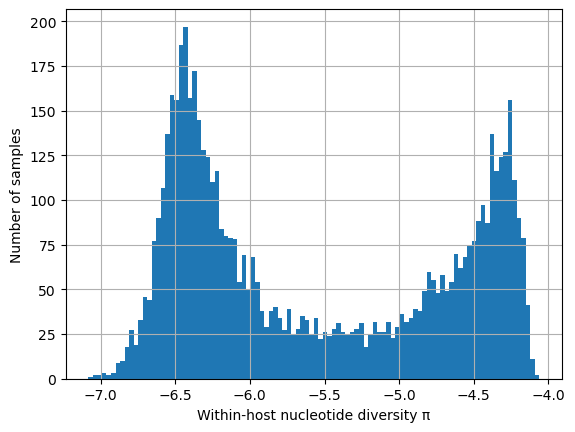

In [23]:
# All regions - only SNPs with maf < 0.01

with open(data_path + "230317_het_per_sample_ALL", "r") as filepath:
    het_per_sample = json.load(filepath)
    
selected_snps = 494829 # this is <0.01 maf, total is 502221
coding_positions = 12028350 # from Gardner et al 2002

convert_het_to_pi = selected_snps / coding_positions

het_per_sample_nonzero = [convert_het_to_pi * x for x in het_per_sample if x != 0]
log_het_per_sample = [math.log(x, 10) for x in het_per_sample_nonzero]
plt.hist(log_het_per_sample, bins = 100)
plt.xlabel('Within-host nucleotide diversity \u03C0')
plt.ylabel('Number of samples')
plt.grid()
plt.show()


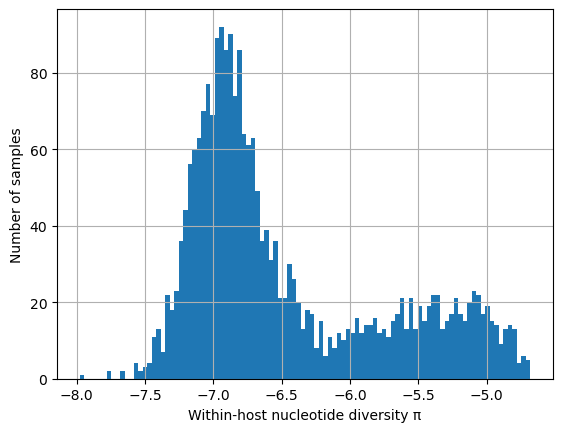

In [24]:
# Southeast Asia - only SNPs with maf < 0.01 

with open(data_path + "230316_het_per_sample_SEA", "r") as filepath:
    het_per_sample = json.load(filepath)
    
coding_positions = 12028350 # from Gardner et al 2002

convert_het_to_pi = filtered_snps / coding_positions

het_per_sample_nonzero = [convert_het_to_pi * x for x in het_per_sample if x != 0]
log_het_per_sample = [math.log(x, 10) for x in het_per_sample_nonzero]
plt.hist(log_het_per_sample, bins = 100)
plt.xlabel('Within-host nucleotide diversity \u03C0')
plt.ylabel('Number of samples')
plt.grid()
plt.show()

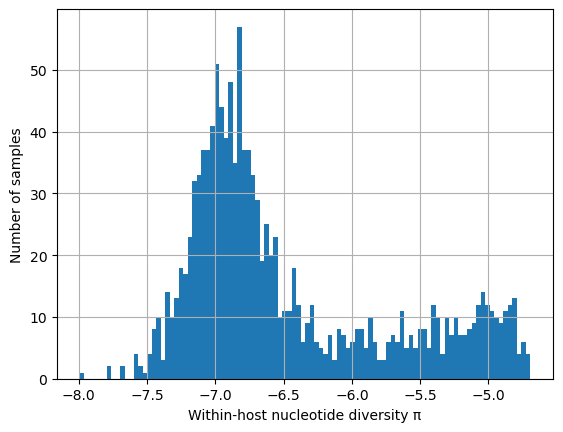

In [110]:
# Eastern Southeast Asia - only SNPs with maf < 0.01 

with open(data_path + "230316_het_per_sample_ESEA", "r") as filepath:
    het_per_sample = json.load(filepath)
    
coding_positions = 12028350 # from Gardner et al 2002

convert_het_to_pi = filtered_snps / coding_positions

het_per_sample_nonzero = [convert_het_to_pi * x for x in het_per_sample if x != 0]
log_het_per_sample = [math.log(x, 10) for x in het_per_sample_nonzero]
plt.hist(log_het_per_sample, bins = 100)
plt.xlabel('Within-host nucleotide diversity \u03C0')
plt.ylabel('Number of samples')
plt.grid()
plt.show()

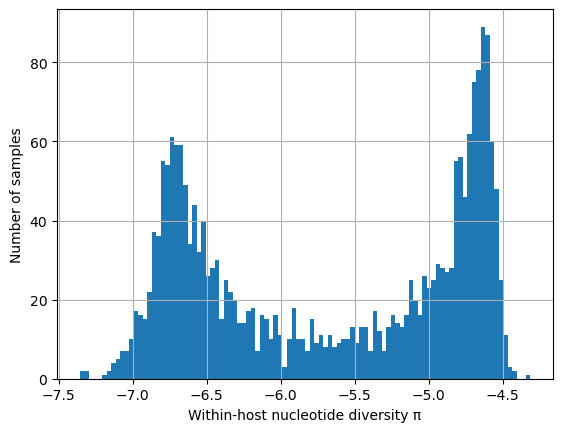

In [103]:
# West Africa - only SNPs with maf < 0.01 

with open(data_path + "230316_het_per_sample_WAF", "r") as filepath:
    het_per_sample = json.load(filepath)
    
coding_positions = 12028350 # from Gardner et al 2002

convert_het_to_pi = filtered_snps / coding_positions

het_per_sample_nonzero = [convert_het_to_pi * x for x in het_per_sample if x != 0]
log_het_per_sample = [math.log(x, 10) for x in het_per_sample_nonzero]
plt.hist(log_het_per_sample, bins = 100)
plt.xlabel('Within-host nucleotide diversity \u03C0')
plt.ylabel('Number of samples')
plt.grid()
plt.show()